In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import qutip as qt 
from ECD_control.ECD_optimization.batch_optimizer import BatchOptimizer
from ECD_control.ECD_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


Need tf version 2.3.0 or later. Using tensorflow version: 2.5.0-rc2


Need tf version 2.3.0 or later. Using tensorflow version: 2.5.0-rc2



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8762164512566586898]

In [4]:
#The target oscillator state.
N =40
Fock = 3
psi_t = qt.basis(N,3) #target state

In [48]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
'N_blocks' : 7, #circuit depth
'N_multistart' : 200, #Batch size (number of circuit optimizations to run in parallel)
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.995, #terminal fidelitiy
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))], #qubit tensor oscillator, start in |g> |0>
'target_states' : [qt.tensor(qt.basis(2,1), psi_t)], #end in |e> |target>.
'name' : 'Fock %d' % Fock, #name for printing and saving
'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

In [5]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(**opt_params)

#print optimization info. 
opt.print_info()

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-2.73956+0.70827j  0.24079+0.26742j -0.77625+2.09885j -1.81815-1.52624j
  2.27769+1.60903j -0.34043+0.01552j  0.73853+0.24796j]
alphas:        [0.+0.j]
phis (deg):    [  0.       43.89198 175.67824 105.9808   23.6923  -60.76004  70.85164]
thetas (deg):  [ -88.41856   44.77093  -76.31822  158.60266  178.51094   96.7271
 -130.35992]
Max Fidelity:  0.149185




In [49]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python consle,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
opt.optimize()

Start time: 2022-01-23 19:40:31
 Epoch: 5 / 200 Max Fid: 0.991298 Avg Fid: 0.830486 Max dFid: 0.044713 Avg dFid: 0.004180 Elapsed time: 0:01:11.158861 Remaing time: 0:46:15.195576

KeyboardInterrupt: 

In [50]:
#can print info, including the best circuit found.
opt.print_info() 

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [ 0.95349+2.43066j -0.04181-0.9151j  -1.163  +1.61765j  1.1472 +0.15891j
 -0.23717-0.45659j  0.12051-0.25753j -0.06487-0.03857j]
alphas:        [0.+0.j]
phis (deg):    [   0.       -69.65359 -124.65845  -44.51379   43.41273  146.47249
  121.23855]
thetas (deg):  [  89.39082  142.20554 -121.71408   46.12947  -54.30245 -100.38507
  -81.32021]
Max Fidelity:  0.991427




In [51]:
#can also get the best circuit parameters directly, could save this to a .npz file.
best_circuit =  opt.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)

{'fidelity': 0.9914272, 'betas': array([ 0.9534872 +2.4306645j , -0.04181007-0.9151017j ,
       -1.1629975 +1.6176493j ,  1.1471978 +0.15890744j,
       -0.2371666 -0.45659375j,  0.12051004-0.25753298j,
       -0.06486859-0.03857371j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.       , -1.2156845, -2.1757004, -0.7769122,  0.7576952,
        2.5564272,  2.1160119], dtype=float32), 'thetas': array([ 1.5601642 ,  2.4819548 , -2.1243114 ,  0.80511117, -0.9477565 ,
       -1.75205   , -1.4193053 ], dtype=float32)}


In [5]:
#Analysis of the results. Can load the .h5 file.
#all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I  recommend using "HDFview" software to understand data structure
#filename = opt.filename
filename = 'Fock %d.h5' % Fock
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

N_blocks: 7
N_cav: 40
N_multistart: 200
alpha_scale: 1.0
beta_scale: 3.0
comment: 
dfid_stop: 1e-06
elapsed_time_s: 71.15886092185974
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: Fock 3
no_CD_end: False
optimization_type: state transfer
term_fid: 0.995
termination_reason: outside termination
theta_scale: 3.141592653589793
use_displacements: False
use_phase: False
filename: Fock 3.h5

Best circuit parameters found:
betas:         [ 0.9596 +2.41752j -0.04204-0.90925j -1.1594 +1.62482j  1.14962+0.15731j
 -0.23686-0.45647j  0.12095-0.25499j -0.06589-0.03653j]
alphas:        [0.+0.j]
phis (deg):    [   0.       -69.34492 -125.06026  -43.804     42.70121  146.85768
  120.90807]
thetas (deg):  [  89.43394  141.91464 -122.04208   46.23262  -54.766   -100.32357
  -81.3539 ]
Max Fidelity:  0.991298




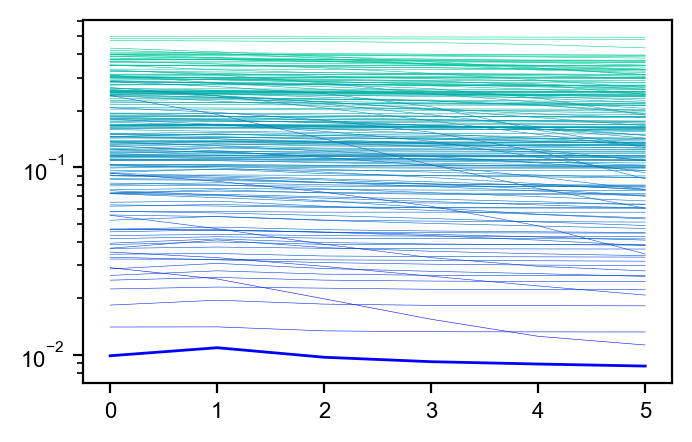

In [6]:
#We can plot the fidelities of the different parallel optimizations. 
# x axis is epoch
analysis.plot_fidelities()

In [10]:
#Can also get the "best circuit" from a loaded analysis object
best_circuit = analysis.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)

{'fidelity': 0.991298, 'betas': array([ 0.9595963 +2.41752j   , -0.04204008-0.90925455j,
       -1.159403  +1.624819j  ,  1.1496165 +0.15731029j,
       -0.23685928-0.4564713j ,  0.12094921-0.25498876j,
       -0.06589048-0.03652994j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.       , -1.2102971, -2.1827133, -0.764524 ,  0.7452767,
        2.5631502,  2.110244 ], dtype=float32), 'thetas': array([ 1.5609167 ,  2.476878  , -2.130036  ,  0.80691147, -0.955847  ,
       -1.7509767 , -1.4198934 ], dtype=float32)}


In [11]:
#Now, we can take the parameters found (betas, phis, and thetas)
#and use them to produce a ECD oscillator and qubit pulse.
#This requies us to specify the calibrated experimental parameters.

#The following parameters for the oscillator will be used to build the oscillator pulse.
#Here, assume that a gaussian displacement pulse to alpha=1.0 has been calibrated.
storage_params = {
        "chi_kHz": 33, #dispersive shift in kHz
        "chi_prime_Hz": 1, #second order dispersive shift in Hz
        "Ks_Hz": 0, #Kerr correction not implemented here.
        "unit_amp": 0.01, #DAC amplitude (at maximum of pulse) for gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement pulse sigma
        "chop": 4, #oscillator displacement pulse chop (number of sigmas to include in gaussian pulse)
    }

#In a similar way, the qubit pulse parameters will be specified by a calibrated pi pulse.
#unit_amp is the DAC amplitude (at maximum of pulse) for a calibrated gaussian pi pulse, with sigma and chop specified
qubit_params = {'unit_amp': 0.5, 'sigma': 6, 'chop': 4} #parameters for qubit pi pulse.


#creating the "Fake storage" and "Fake qubit" objects which are used
#for pulse cration
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The maximum displacement used during the ECD gates.
alpha_CD = 30
#Small delay to insert between oscillator and qubit pulses to ensure timing is okay.
buffer_time = 4

In [12]:
#From these calibrations, the storage and qubit objects calculate the
#conversion between DAC amplitude, and drive amplitude in MHz.
#so, [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz 
#and [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz.
#These parameters also represent the maximum drive amplitude,
#since the DAC max amplitude is 1 (assuming amplifiers don't saturate.)
print('Maximum oscillator drive amplitude: |epsilon|/2*pi < %.3f MHz' % storage.epsilon_m_MHz)
print('Maximum qubit drive amplitude: |Omega|/2*pi < %.3f MHz' % qubit.Omega_m_MHz)

Maximum oscillator drive amplitude: |epsilon|/2*pi < 690.790 MHz
Maximum qubit drive amplitude: |Omega|/2*pi < 40.468 MHz


In [13]:
#generating the oscillator and qubit pulses (epsilon and Omega)
#set 'chi_prime_correction = True' to correct for linear part of chi'
#final_disp = True will implement final ECD gate as a gaussian displacement instead of full ECD gate.
#This option is useful if the qubit and oscillator are disentangled after the gate.
pulse_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)

#The dictionary will contain the pulses, in DAC units.
#Also, the displacements used for each ECD gate (the "alphas")
cavity_dac_pulse, qubit_dac_pulse,alphas = pulse_dict['cavity_dac_pulse'], pulse_dict['qubit_dac_pulse'], pulse_dict['alphas']
print('alphas:')
print(alphas)

C:\ProgramData\Miniconda3\envs\opt3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


alphas:
[30.0, 30.052430293560747, 30.0, 30.073841221480357, 26.70114839328176, 14.958425310615674]


Text(0.5, 0, 'ns')

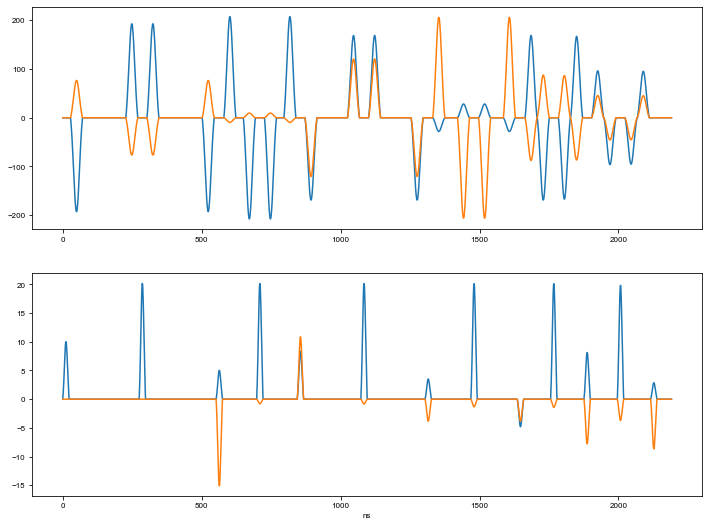

In [14]:
#plotting the pulse, in units of MHz. It could also be fed into a time-domain simulation.
fig, axs = plt.subplots(2,1)
axs[0].plot(np.real(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[0].plot(np.imag(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[1].plot(np.real(qubit.Omega_m_MHz*qubit_dac_pulse))
axs[1].plot(np.imag(qubit.Omega_m_MHz*qubit_dac_pulse))
plt.xlabel('ns')